# Calling Azure ML model

<img src="https://kwmp.ca/wp-content/uploads/2018/04/titanic-the-musical-1024x538.jpg">

## 1. Information session

In [57]:
import sys
print("Version Python :",sys.version)

Version Python : 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [58]:
import datetime
date = datetime.datetime.now()
print("Date Heure :", str(date))

Date Heure : 2020-10-01 10:13:09.976703


## 2. Importation des librairies

In [59]:
import urllib.request
import json
import os
import ssl

In [60]:
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [61]:
ws = Workspace.from_config()

experiment_name = 'AutoMLTitanicSDK'

In [62]:
def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

## 3. Premier exemple

In [63]:
# URL de l'image à analyser
image_url = "https://github.com/retkowsky/images/blob/master/titanic1.jpg?raw=true"

<img src="https://github.com/retkowsky/images/blob/master/titanic1.jpg?raw=true" width="600">

### 3.1 Exemple Face Detection Azure

In [64]:
import requests
import matplotlib.pyplot as plt
import json
from PIL import Image
from io import BytesIO

In [65]:
# Ma clef
subscription_key = "TOBEREPLACED"
assert subscription_key

In [66]:
# Endpoint API
vision_base_url = "https://westeurope.api.cognitive.microsoft.com/vision/v2.0/"
analyze_url = vision_base_url + "analyze"

In [67]:
headers = {'Ocp-Apim-Subscription-Key': subscription_key }
params  = {'visualFeatures': 'Categories,Description,Color'}
data    = {'url': image_url}
response = requests.post(analyze_url, headers=headers, params=params, json=data)
response.raise_for_status()

analysis = response.json()

print(json.dumps(response.json()))
image_caption = analysis["description"]["captions"][0]["text"].capitalize()

{"categories": [{"name": "people_portrait", "score": 0.6875, "detail": {"celebrities": [{"name": "Leonardo DiCaprio", "confidence": 0.7701433300971985, "faceRectangle": {"left": 580, "top": 196, "width": 418, "height": 418}}]}}], "color": {"dominantColorForeground": "Black", "dominantColorBackground": "Black", "dominantColors": ["Black", "Brown"], "accentColor": "545644", "isBwImg": false, "isBWImg": false}, "description": {"tags": ["person", "man", "necktie", "suit", "indoor", "clothing", "wearing", "photo", "camera", "posing", "looking", "smiling", "front", "shirt", "sitting", "dressed", "young", "standing", "glasses", "people", "holding", "wedding"], "captions": [{"text": "Leonardo DiCaprio wearing a suit and tie smiling at the camera", "confidence": 0.9927912467878292}]}, "requestId": "003e65d8-3194-4141-a101-ab5d04018caf", "metadata": {"height": 900, "width": 1600, "format": "Jpeg"}}


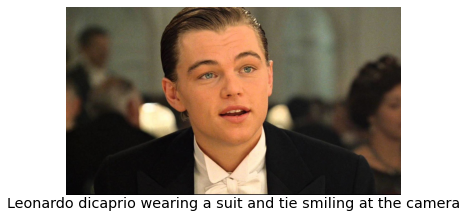

In [68]:
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
plt.axis("off")
_ = plt.title(image_caption, size="x-large", y=-0.1)
plt.show()

### 3.2 Estimation de l'âge

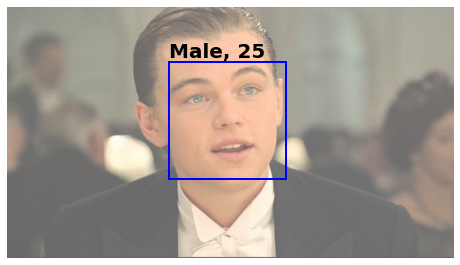

In [69]:
subscription_key = "TOBEREPLACED"

assert subscription_key

face_api_url = 'https://westeurope.api.cognitive.microsoft.com/face/v1.0/detect'
image_url = 'https://github.com/retkowsky/images/blob/master/titanic1.jpg?raw=true'

import requests
from IPython.display import HTML

headers = { 'Ocp-Apim-Subscription-Key': subscription_key }
    
params = {
    'returnFaceId': 'true',
    'returnFaceLandmarks': 'false',
    'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
}

response = requests.post(face_api_url, params=params, headers=headers, json={"url": image_url})
faces = response.json()
HTML("<font size=5>Detected <font color='blue'>%d</font> faces in the image</font>"%len(faces))
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib import patches
from io import BytesIO

response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

plt.figure(figsize=(8,8))
ax = plt.imshow(image, alpha=0.6)
for face in faces:
    fr = face["faceRectangle"]
    fa = face["faceAttributes"]
    origin = (fr["left"], fr["top"])
    p = patches.Rectangle(origin, fr["width"], fr["height"], fill=False, linewidth=2, color='b')
    ax.axes.add_patch(p)
    plt.text(origin[0], origin[1], "%s, %d"%(fa["gender"].capitalize(), fa["age"]), fontsize=20, weight="bold", va="bottom")
_ = plt.axis("off")

### 3.3 Génération des données en entrée du modèle de ML

In [70]:
leonardo = {
    "Inputs": {
          "WebServiceInput0":
          [
              {
                    'Passenger': "1",
                    'Survived': "false",
                    'Class': "Lower Class",
                    'Name': "Braund, Mr. Owen Harris",
                    'Sex': "male",
                    'Age': "25",
                    'Siblings or Spouses': "0",
                    'Parents or children': "0",
                    'Ticket': "A/5 21171",
                    'Fare': "7.25",
                    'Cabin': "",
                    'Port': "S",
              },
          ],
    },
    "GlobalParameters":  {
    }
}

In [71]:
leonardo

{'Inputs': {'WebServiceInput0': [{'Passenger': '1',
    'Survived': 'false',
    'Class': 'Lower Class',
    'Name': 'Braund, Mr. Owen Harris',
    'Sex': 'male',
    'Age': '25',
    'Siblings or Spouses': '0',
    'Parents or children': '0',
    'Ticket': 'A/5 21171',
    'Fare': '7.25',
    'Cabin': '',
    'Port': 'S'}]},
 'GlobalParameters': {}}

### 3.4 Appel au modèle de ML déployé par Azure ML

In [72]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.


body = str.encode(json.dumps(leonardo))

url = 'TOBEREPLACED'
api_key = 'TOBEREPLACED' # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))

b'{"Results": {"WebServiceOutput0": [{"Survived": true, "Class": "Lower Class", "Sex": "male", "Age": 25.0, "Siblings or Spouses": 0, "Parents or children": 0, "Port": "S", "Scored Labels": false, "Scored Probabilities": 0.18229166666666666}]}}'


> ### Résultat : <span style="color: red;">*Pas de survie* </span>

## 4. Second exemple

<img src="https://github.com/retkowsky/images/blob/master/titanic02.jpg?raw=true" width="600">

In [86]:
kate = {
    "Inputs": {
          "WebServiceInput0":
          [
              {
                    'Passenger': "1",
                    'Survived': "false",
                    'Class': "Upper Class",
                    'Name': "Braund, Mr. Owen Harris",
                    'Sex': "female",
                    'Age': "20",
                    'Siblings or Spouses': "0",
                    'Parents or children': "0",
                    'Ticket': "A/5 21171",
                    'Fare': "7.25",
                    'Cabin': "",
                    'Port': "S",
              },
          ],
    },
    "GlobalParameters":  {
    }
}

In [87]:
kate

{'Inputs': {'WebServiceInput0': [{'Passenger': '1',
    'Survived': 'false',
    'Class': 'Upper Class',
    'Name': 'Braund, Mr. Owen Harris',
    'Sex': 'female',
    'Age': '20',
    'Siblings or Spouses': '0',
    'Parents or children': '0',
    'Ticket': 'A/5 21171',
    'Fare': '7.25',
    'Cabin': '',
    'Port': 'S'}]},
 'GlobalParameters': {}}

In [88]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.


body = str.encode(json.dumps(kate))

url = 'TOBEREPLACED'
api_key = 'TOBEREPLACED' # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))

b'{"Results": {"WebServiceOutput0": [{"Survived": true, "Class": "Upper Class", "Sex": "female", "Age": 20.0, "Siblings or Spouses": 0, "Parents or children": 0, "Port": "S", "Scored Labels": true, "Scored Probabilities": 0.875}]}}'


> ### Résultat : <span style="color: green;">*Survie* </span>